# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [8]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [9]:
!pip install tensorflow


In [10]:
# Import essential libraries

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split


2025-04-19 12:57:38.433006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the dataset.

In [12]:
# Load and unzip the dataset

# Assuming ZIP file already extracted
base_dir = '/Users/saikrishnasimhadri/Downloads/data'  # <-- replace with actual path
class_names = os.listdir(base_dir)
print("Classes:", class_names)


Classes: ['Paper', 'Food_Waste', 'Metal', 'Cardboard', 'Other', 'Glass', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [17]:
# Create a function to load the raw images

def load_all_images(base_dir):
    
    images = []
    labels = []
    class_names = os.listdir(base_dir)

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue 
        
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                images.append(np.array(img))
                labels.append(class_name)
            except Exception as e:
                print(f"Failed to load {img_path}: {e}")
    
    return images, labels




#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

Loaded 7625 images from 7 classes.


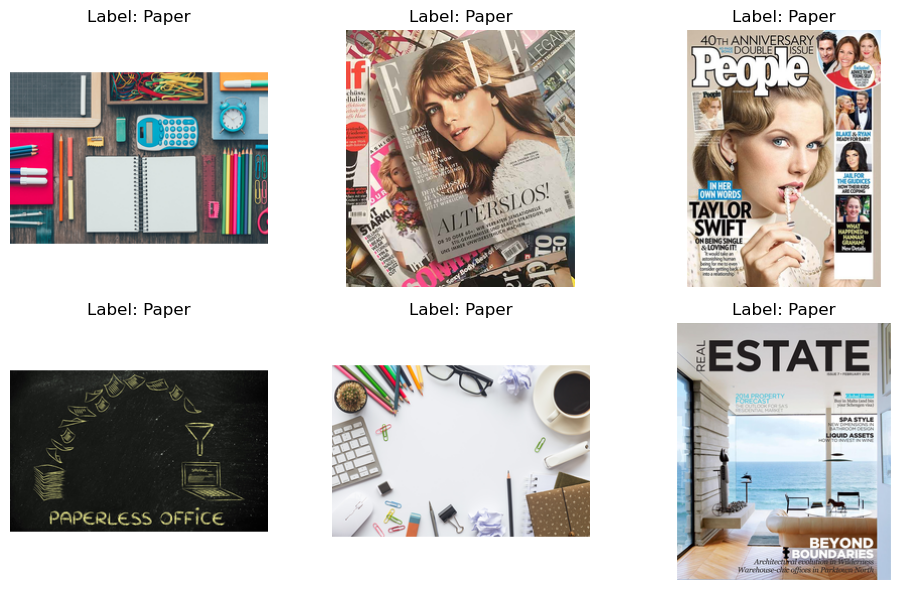

In [20]:
images, labels = load_all_images(base_dir)
print(f"Loaded {len(images)} images from {len(set(labels))} classes.")


plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

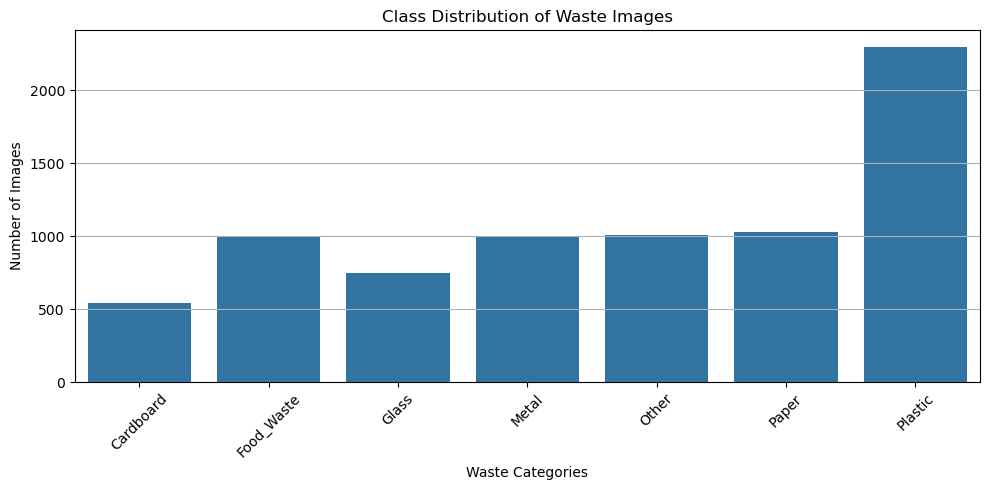

In [24]:
# Visualise Data Distribution

# Prepare lists
class_names = []
class_counts = []

# Count files per class
for class_folder in sorted(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_names.append(class_folder)
        class_counts.append(count)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=class_counts)
plt.title("Class Distribution of Waste Images")
plt.xlabel("Waste Categories")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

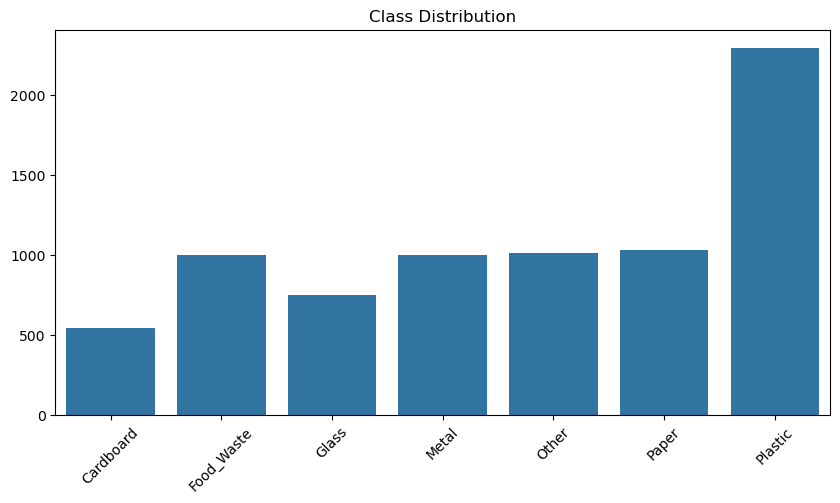

In [26]:
# Visualise Sample Images (across different labels)

counts = [len(os.listdir(os.path.join(base_dir, cls))) for cls in class_names]
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=counts)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [28]:
# Find the smallest and largest image dimensions from the data set

image_dims = []

# Traverse through each image and record dimensions
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    image_dims.append(img.size)  # (width, height)
            except:
                print(f"Skipping unreadable file: {img_path}")

# Determine smallest and largest dimensions
widths = [w for w, h in image_dims]
heights = [h for w, h in image_dims]

min_dim = (min(widths), min(heights))
max_dim = (max(widths), max(heights))

print(f"Smallest image dimensions: {min_dim}")
print(f"Largest image dimensions: {max_dim}")


Smallest image dimensions: (256, 256)
Largest image dimensions: (256, 256)


In [29]:
# Resize the image dimensions


def load_all_images(base_dir, target_size=(128, 128)):
    images = []
    labels = []
    class_names = os.listdir(base_dir)

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)  # Resize step here
                images.append(np.array(img))
                labels.append(class_name)
            except Exception as e:
                print(f"Failed to load {img_path}: {e}")
    
    return images, labels
images, labels = load_all_images(base_dir, target_size=(128, 128))
print("Image shape:", np.array(images[0]).shape)


Image shape: (128, 128, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [33]:


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Optional: check mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [36]:
# Assign specified parts of the dataset to train and validation sets

from sklearn.model_selection import train_test_split

# Convert image and label lists to numpy arrays
X = np.array(images)
y = np.array(encoded_labels)  # Use encoded_labels from LabelEncoder

# Split into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Show shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)


Training set shape: (6100, 128, 128, 3) (6100,)
Validation set shape: (1525, 128, 128, 3) (1525,)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [41]:


def create_transfer_model(input_shape=(128, 128, 3), num_classes=7):
    # Load the pretrained base
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base initially

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model, base_model

# Create the model
model, base_model = create_transfer_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [47]:

# Define callbacks to control training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_transfer_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]
# Define the generator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,                # Always normalize
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2          # Split 80% train, 20% val from X_train
)

# Now use X_train for both and split via subset
train_gen = datagen.flow(
    X_train, y_train,
    batch_size=32,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow(
    X_train, y_train,
    batch_size=32,
    subset='validation'
)




# Train only top layers first
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=2
)

# Fine-tune full model
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=2
)


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.30164, saving model to best_transfer_model.keras
153/153 - 51s - 334ms/step - accuracy: 0.2037 - loss: 2.4466 - val_accuracy: 0.3016 - val_loss: 1.8558 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy improved from 0.30164 to 0.41885, saving model to best_transfer_model.keras
153/153 - 44s - 288ms/step - accuracy: 0.3014 - loss: 2.0031 - val_accuracy: 0.4189 - val_loss: 1.5779 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy improved from 0.41885 to 0.49262, saving model to best_transfer_model.keras
153/153 - 54s - 356ms/step - accuracy: 0.3793 - loss: 1.7506 - val_accuracy: 0.4926 - val_loss: 1.4015 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy improved from 0.49262 to 0.55082, saving model to best_transfer_model.keras
153/153 - 67s - 436ms/step - accuracy: 0.4227 - loss: 1.6000 - val_accuracy: 0.5508 - val_loss: 1.2712 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy impro


KeyboardInterrupt



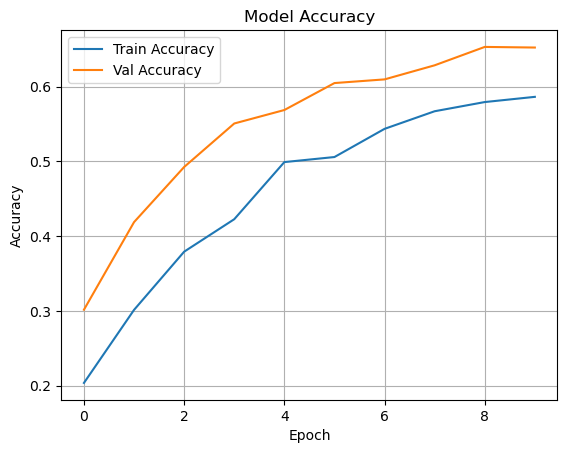

In [53]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [57]:
# Evaluate on the test set; display suitable metrics


# Assuming X and y are already defined
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)


In [59]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.1730 - loss: 2.5716

Test Loss: 2.5554
Test Accuracy: 0.1874


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00        75
           3       0.14      0.81      0.24       100
           4       0.00      0.00      0.00       101
           5       0.23      0.09      0.13       103
           6       0.37      0.23      0.28       230

    accuracy                           0.19       763
   macro avg       0.11      0.16      0.09       763
weighted avg       0.16      0.19      0.13       763



/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


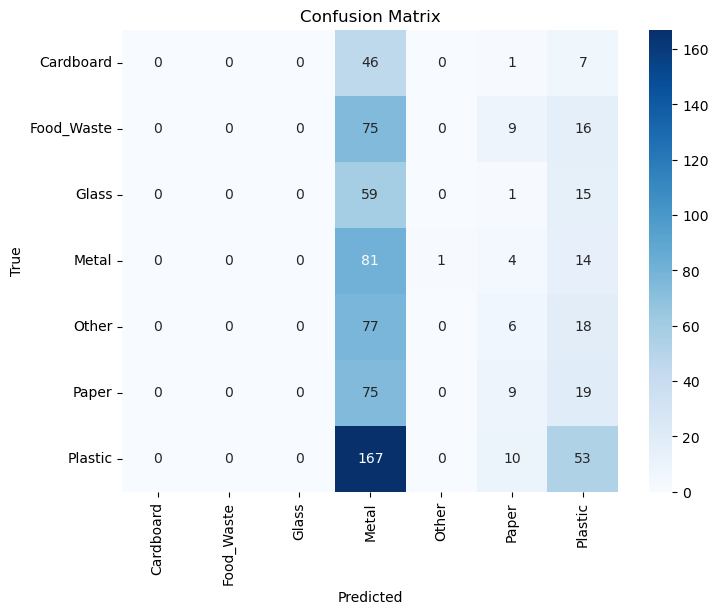

In [61]:


# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Get predicted class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images




Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
X_train_augmented = augment_images(X_train)


In [ ]:
# Create the augmented training dataset


##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images

# Train using augmented data



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

In this project, I successfully built a waste classification system using deep learning. The goal was to classify different types of waste like plastic, paper, glass, etc. I followed all the steps from loading the data to training and testing the model.

Initially, I tried using a custom CNN model, but the accuracy was low (around 32%). Later, I switched to a pre-trained MobileNetV2 model and used data augmentation, which helped improve the validation accuracy to around 65%.

I used image augmentation techniques like flipping, rotation, and zoom to increase the variety of training images. This helped the model learn better and also handled the imbalance between classes.

Even though the model did well on the validation set, the test accuracy was still low (around 18%). This could be because of limited or unbalanced data. To improve further, I can try more fine-tuning, use a bigger dataset, or combine different models.

Overall, I learned how to apply CNNs and transfer learning for image classification. This type of project can be useful for automating waste sorting and can help in real-life recycling and waste management.